In [2]:
from __future__ import annotations

import re
from pathlib import Path
from collections import defaultdict
import random
from itertools import permutations

import numpy as np
import pandas as pd
import torch
import torchaudio
import soundfile as sf
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA



In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PROJECT_ROOT = Path("/home/SpeakerRec/BioVoice")  

CLEAN_DIR = PROJECT_ROOT / "data" / "wavs"
TTS_DIR   = PROJECT_ROOT / "data" / "tts" / "f5"  
OUT_DIR   = PROJECT_ROOT / "output"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("DEVICE:", DEVICE)
print("CLEAN_DIR:", CLEAN_DIR)
print("TTS_DIR:", TTS_DIR)


DEVICE: cuda
CLEAN_DIR: /home/SpeakerRec/BioVoice/data/wavs
TTS_DIR: /home/SpeakerRec/BioVoice/data/tts/f5


In [4]:
redim_model = torch.hub.load(
    "IDRnD/ReDimNet",
    "ReDimNet",
    model_name="b2",
    train_type="ptn",
    dataset="vox2",
).to(DEVICE).eval()



Using cache found in /home/SpeakerRec/.cache/torch/hub/IDRnD_ReDimNet_master


In [5]:
TARGET_SR = 16000

def load_audio_mono(path: Path) -> tuple[torch.Tensor, int]:
    """
    Returns: (wav[1, T] float32, sr)
    Uses torchaudio.load if possible; if it fails due to torchcodec etc, falls back to soundfile.
    """
    try:
        wav, sr = torchaudio.load(path.as_posix())  # [C, T]
        if wav.dtype != torch.float32:
            wav = wav.float()
        if wav.ndim == 1:
            wav = wav.unsqueeze(0)
        if wav.shape[0] > 1:
            wav = wav[:1, :]  
        return wav, int(sr)
    except Exception:
        audio, sr = sf.read(path.as_posix(), dtype="float32", always_2d=True)  # [T, C]
        audio = audio.mean(axis=1)  # mono [T]
        wav = torch.from_numpy(audio).unsqueeze(0)  # [1, T]
        return wav, int(sr)

def resample_if_needed(wav: torch.Tensor, sr: int, target_sr: int = TARGET_SR) -> torch.Tensor:
    if sr == target_sr:
        return wav
    return torchaudio.functional.resample(wav, sr, target_sr)

def embed_with_redim(path: Path) -> np.ndarray:
    wav, sr = load_audio_mono(path)
    wav = resample_if_needed(wav, sr, TARGET_SR)
    wav = wav.to(DEVICE)
    with torch.no_grad():
        emb = redim_model(wav)  # [1, 192]
    return emb.squeeze(0).cpu().numpy().astype("float32")



In [6]:
def parse_clean_speaker(p: Path) -> str:
    return p.stem.split("_")[0]

_tts_re1 = re.compile(r"^(idan|yoav|eden)_(\d{2})$")                 
_tts_re2 = re.compile(r"^(idan|yoav|eden)_(\d{3})_cloned$")          
_tts_re3 = re.compile(r"^(idan|yoav|eden)_(\d{3})_f5tts$")            

def parse_tts_file(p: Path) -> tuple[str, int] | None:
    stem = p.stem
    m = _tts_re1.match(stem)
    if m:
        return m.group(1), int(m.group(2))
    m = _tts_re2.match(stem)
    if m:
        # map 001 -> 1
        return m.group(1), int(m.group(2))
    m = _tts_re3.match(stem)
    if m:
        return m.group(1), int(m.group(2))
    spk = stem.split("_")[0]
    nums = re.findall(r"\d+", stem)
    if spk in {"idan", "yoav", "eden"} and nums:
        return spk, int(nums[-1])
    return None


clean_files = sorted(CLEAN_DIR.glob("*.wav"))
assert len(clean_files) > 0, f"No clean wavs found in {CLEAN_DIR}"

tts_files = sorted(TTS_DIR.rglob("*.wav")) if TTS_DIR.exists() else []
print("Clean count:", len(clean_files))
print("TTS count:", len(tts_files))

df_clean = pd.DataFrame(
    [{"file": str(p), "speaker": parse_clean_speaker(p), "kind": "clean"} for p in clean_files]
)

tts_rows = []
for p in tts_files:
    parsed = parse_tts_file(p)
    if parsed is None:
        continue
    spk, idx = parsed
    tts_rows.append({"file": str(p), "speaker": spk, "sentence_idx": idx, "kind": "tts"})

df_tts = pd.DataFrame(tts_rows).sort_values(["speaker", "sentence_idx"]).reset_index(drop=True)

print(df_clean.head())
print(df_tts.head())
print("Clean speakers:", sorted(df_clean["speaker"].unique()))
print("TTS speakers:", sorted(df_tts["speaker"].unique()))
print("TTS sentence idx range:", (df_tts["sentence_idx"].min() if len(df_tts) else None,
                                 df_tts["sentence_idx"].max() if len(df_tts) else None))



Clean count: 92
TTS count: 90
                                               file speaker   kind
0  /home/SpeakerRec/BioVoice/data/wavs/eden_001.wav    eden  clean
1  /home/SpeakerRec/BioVoice/data/wavs/eden_002.wav    eden  clean
2  /home/SpeakerRec/BioVoice/data/wavs/eden_003.wav    eden  clean
3  /home/SpeakerRec/BioVoice/data/wavs/eden_004.wav    eden  clean
4  /home/SpeakerRec/BioVoice/data/wavs/eden_005.wav    eden  clean
                                                file speaker  sentence_idx  \
0  /home/SpeakerRec/BioVoice/data/tts/f5/eden_01.wav    eden             1   
1  /home/SpeakerRec/BioVoice/data/tts/f5/eden_02.wav    eden             2   
2  /home/SpeakerRec/BioVoice/data/tts/f5/eden_03.wav    eden             3   
3  /home/SpeakerRec/BioVoice/data/tts/f5/eden_04.wav    eden             4   
4  /home/SpeakerRec/BioVoice/data/tts/f5/eden_05.wav    eden             5   

  kind  
0  tts  
1  tts  
2  tts  
3  tts  
4  tts  
Clean speakers: ['eden', 'idan', 'yoav']
TTS 

In [7]:
def compute_embeddings_with_cache(df_in: pd.DataFrame, cache_file: Path) -> np.ndarray:
    files = df_in["file"].tolist()
    if cache_file.exists():
        pack = np.load(cache_file, allow_pickle=True)
        cached_files = pack["files"].tolist()
        if cached_files == files:
            print("Loaded embeddings from cache:", cache_file)
            return pack["E"].astype("float32")

    embs = []
    for f in tqdm(files, desc=f"Embedding {cache_file.stem}"):
        embs.append(embed_with_redim(Path(f)))
    E = np.vstack(embs).astype("float32")

    np.savez_compressed(cache_file, files=np.array(files, dtype=object), E=E)
    print("Saved embeddings cache to:", cache_file)
    return E

clean_cache = OUT_DIR / "redim_clean_embeddings_b2_vox2.npz"
tts_cache   = OUT_DIR / "redim_tts_embeddings_b2_vox2.npz"

E_clean = compute_embeddings_with_cache(df_clean, clean_cache)
E_tts   = compute_embeddings_with_cache(df_tts, tts_cache) if len(df_tts) else np.zeros((0, E_clean.shape[1]), dtype="float32")

def l2norm(E: np.ndarray) -> np.ndarray:
    n = np.linalg.norm(E, axis=1, keepdims=True)
    n = np.clip(n, 1e-12, None)
    return E / n

E_clean_n = l2norm(E_clean)
E_tts_n   = l2norm(E_tts) if len(E_tts) else E_tts

print("E_clean:", E_clean_n.shape, "E_tts:", E_tts_n.shape)



Loaded embeddings from cache: /home/SpeakerRec/BioVoice/output/redim_clean_embeddings_b2_vox2.npz
Loaded embeddings from cache: /home/SpeakerRec/BioVoice/output/redim_tts_embeddings_b2_vox2.npz
E_clean: (92, 192) E_tts: (90, 192)


In [8]:
GLOBAL_ENROLL_PER_SPK = 3
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

groups = defaultdict(list)
for i, row in df_clean.iterrows():
    groups[row["speaker"]].append(i)

enroll_idx = []
test_idx = []

for spk, idxs in groups.items():
    idxs = idxs.copy()
    random.shuffle(idxs)

    n_avail = len(idxs)
    if n_avail <= GLOBAL_ENROLL_PER_SPK:
        n_enroll = max(1, n_avail - 1)
    else:
        n_enroll = GLOBAL_ENROLL_PER_SPK

    enroll_idx.extend(idxs[:n_enroll])
    test_idx.extend(idxs[n_enroll:])

enroll_idx = np.array(sorted(enroll_idx))
test_idx   = np.array(sorted(test_idx))

enroll_emb = E_clean_n[enroll_idx]                   # [N_enroll, D]
test_emb   = E_clean_n[test_idx] if len(test_idx) else np.zeros((0, enroll_emb.shape[1]), dtype="float32")

enroll_labels = df_clean.iloc[enroll_idx]["speaker"].to_numpy()
test_labels   = df_clean.iloc[test_idx]["speaker"].to_numpy() if len(test_idx) else np.array([])

print("Enrollment per speaker:", GLOBAL_ENROLL_PER_SPK)
print("Total enrollment:", len(enroll_idx), "Total clean test:", len(test_idx))



Enrollment per speaker: 3
Total enrollment: 9 Total clean test: 83


In [9]:
def predict_by_maxcos(test_E: np.ndarray, enroll_E: np.ndarray, enroll_labels: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Returns (pred_labels, max_scores)
    """
    if len(test_E) == 0:
        return np.array([]), np.array([])
    S = test_E @ enroll_E.T  # [N_test, N_enroll]
    best = np.argmax(S, axis=1)
    pred = enroll_labels[best]
    max_scores = S[np.arange(S.shape[0]), best]
    return pred, max_scores

clean_pred, clean_max = predict_by_maxcos(test_emb, enroll_emb, enroll_labels)
clean_acc = (clean_pred == test_labels).mean() if len(test_labels) else float("nan")
print(f"Clean test accuracy (vs clean enrollment): {clean_acc:.4f}")



Clean test accuracy (vs clean enrollment): 1.0000


In [10]:
if len(df_tts):
    tts_pred, tts_max = predict_by_maxcos(E_tts_n, enroll_emb, enroll_labels)
    df_tts["pred"] = tts_pred
    df_tts["max_sim_to_any_enroll"] = tts_max
    df_tts["correct"] = (df_tts["pred"] == df_tts["speaker"])

    tts_acc = df_tts["correct"].mean()
    print(f"TTS accuracy (pred via clean enrollment): {tts_acc:.4f}")

    print("\nAccuracy by speaker:")
    print(df_tts.groupby("speaker")["correct"].mean().sort_index())

else:
    print("No TTS files indexed. Check TTS_DIR and filename parsing.")



TTS accuracy (pred via clean enrollment): 1.0000

Accuracy by speaker:
speaker
eden    1.0
idan    1.0
yoav    1.0
Name: correct, dtype: float64


[[30  0  0]
 [ 0 30  0]
 [ 0  0 30]]
              precision    recall  f1-score   support

        eden       1.00      1.00      1.00        30
        idan       1.00      1.00      1.00        30
        yoav       1.00      1.00      1.00        30

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



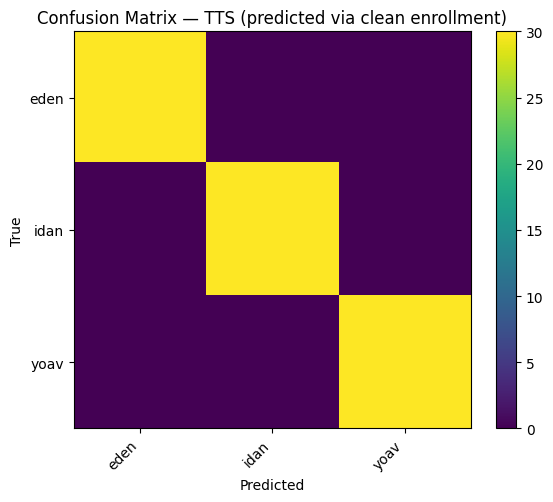

In [11]:
if len(df_tts):
    labels = sorted(df_clean["speaker"].unique())
    cm = confusion_matrix(df_tts["speaker"], df_tts["pred"], labels=labels)
    print(cm)
    print(classification_report(df_tts["speaker"], df_tts["pred"], labels=labels, zero_division=0))

    plt.figure(figsize=(6, 5))
    plt.imshow(cm)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix — TTS (predicted via clean enrollment)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()



  speaker  sentence_idx  max_sim_same_spk  max_sim_other_spk  \
0    eden             1          0.655467           0.257782   
1    eden             2          0.602779           0.187992   
2    eden             3          0.529153           0.196285   
3    eden             4          0.507666           0.177537   
4    eden             5          0.511287           0.128114   

   margin_same_minus_other  
0                 0.397684  
1                 0.414787  
2                 0.332867  
3                 0.330129  
4                 0.383173  


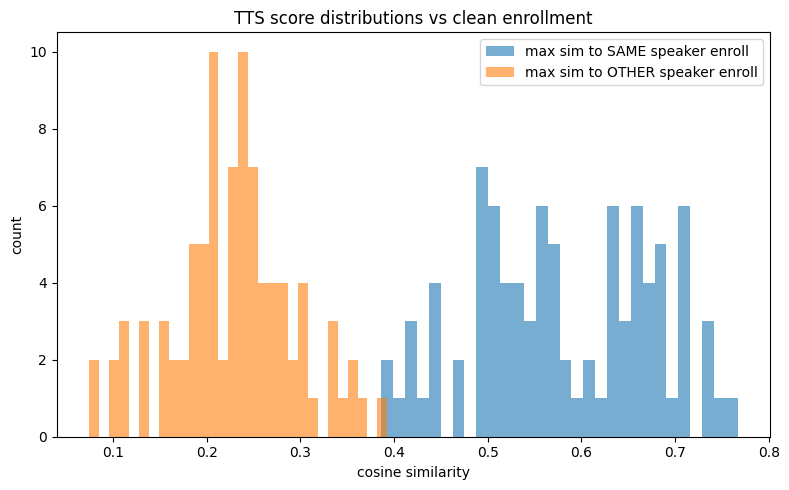

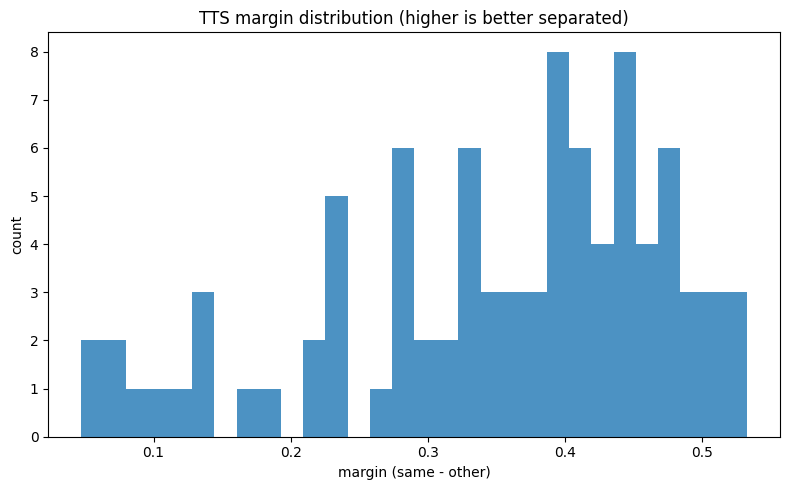

In [12]:
def max_same_other_scores(
    test_E: np.ndarray,
    test_speakers: np.ndarray,
    enroll_E: np.ndarray,
    enroll_speakers: np.ndarray,
) -> tuple[np.ndarray, np.ndarray]:
    """
    For each test sample:
      max_same  = max cosine similarity to enrollment samples with same speaker label
      max_other = max cosine similarity to enrollment samples with other speaker labels
    """
    out_same = np.zeros((len(test_E),), dtype=np.float32)
    out_oth  = np.zeros((len(test_E),), dtype=np.float32)

    for i in range(len(test_E)):
        s = test_speakers[i]
        sims = test_E[i] @ enroll_E.T  # [N_enroll]
        mask_same = (enroll_speakers == s)
        same_vals = sims[mask_same]
        oth_vals  = sims[~mask_same]
        out_same[i] = float(np.max(same_vals)) if len(same_vals) else float("nan")
        out_oth[i]  = float(np.max(oth_vals))  if len(oth_vals) else float("nan")

    return out_same, out_oth

if len(df_tts):
    tts_same, tts_other = max_same_other_scores(
        E_tts_n, df_tts["speaker"].to_numpy(), enroll_emb, enroll_labels
    )
    df_tts["max_sim_same_spk"] = tts_same
    df_tts["max_sim_other_spk"] = tts_other
    df_tts["margin_same_minus_other"] = df_tts["max_sim_same_spk"] - df_tts["max_sim_other_spk"]

    print(df_tts[["speaker", "sentence_idx", "max_sim_same_spk", "max_sim_other_spk", "margin_same_minus_other"]].head())

    plt.figure(figsize=(8, 5))
    plt.hist(df_tts["max_sim_same_spk"], bins=30, alpha=0.6, label="max sim to SAME speaker enroll")
    plt.hist(df_tts["max_sim_other_spk"], bins=30, alpha=0.6, label="max sim to OTHER speaker enroll")
    plt.xlabel("cosine similarity")
    plt.ylabel("count")
    plt.title("TTS score distributions vs clean enrollment")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.hist(df_tts["margin_same_minus_other"], bins=30, alpha=0.8)
    plt.xlabel("margin (same - other)")
    plt.ylabel("count")
    plt.title("TTS margin distribution (higher is better separated)")
    plt.tight_layout()
    plt.show()



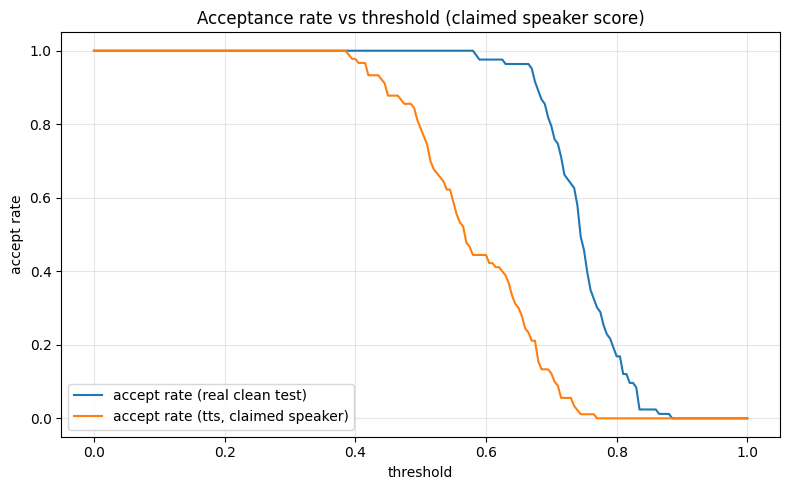

In [13]:
def sweep_accept_rates(scores: np.ndarray, thresholds: np.ndarray) -> np.ndarray:
    return np.array([(scores >= t).mean() for t in thresholds], dtype=np.float32)

if len(df_tts) and len(test_emb):
    clean_same, clean_other = max_same_other_scores(test_emb, test_labels, enroll_emb, enroll_labels)

    thr = np.linspace(0.0, 1.0, 201)

    clean_accept = sweep_accept_rates(clean_same, thr)
    tts_accept   = sweep_accept_rates(df_tts["max_sim_same_spk"].to_numpy(), thr)

    plt.figure(figsize=(8, 5))
    plt.plot(thr, clean_accept, label="accept rate (real clean test)")
    plt.plot(thr, tts_accept, label="accept rate (tts, claimed speaker)")
    plt.xlabel("threshold")
    plt.ylabel("accept rate")
    plt.title("Acceptance rate vs threshold (claimed speaker score)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()



PCA explained variance ratio: [0.3660345  0.19579087]
Total explained variance (2D): 0.5618254


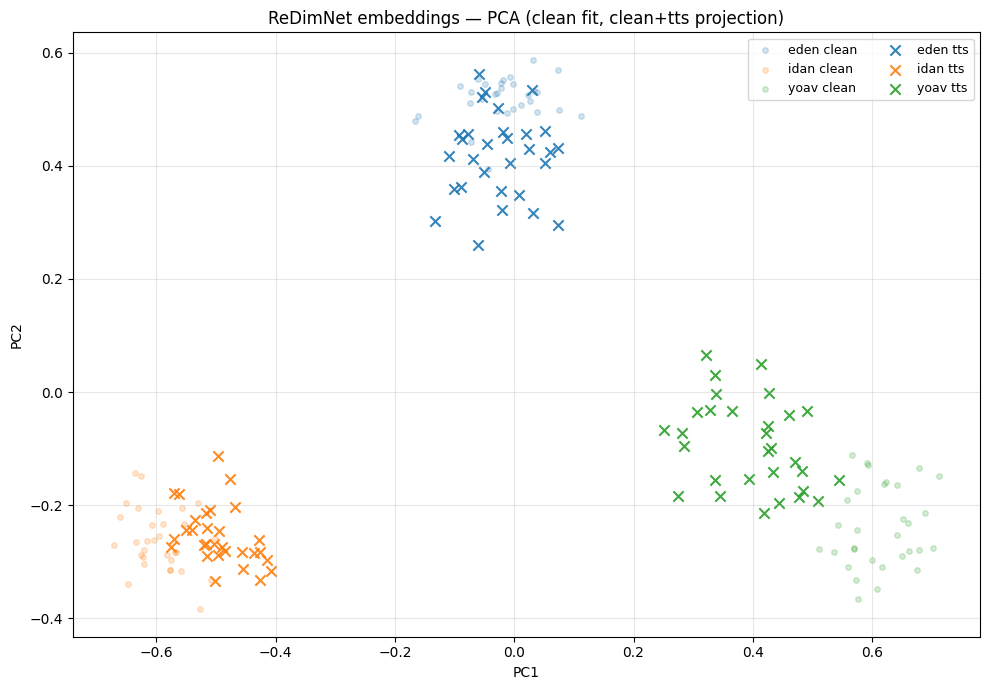

In [14]:
pca = PCA(n_components=2, random_state=0)
pca.fit(E_clean_n)

clean_2d = pca.transform(E_clean_n)
tts_2d   = pca.transform(E_tts_n) if len(df_tts) else np.zeros((0, 2), dtype=np.float32)

print("PCA explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance (2D):", pca.explained_variance_ratio_.sum())

speakers = sorted(df_clean["speaker"].unique())
default_colors = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
color_map = {spk: default_colors[i % len(default_colors)] for i, spk in enumerate(speakers)}

plt.figure(figsize=(10, 7))

# Clean points (faint)
for spk in speakers:
    idx = (df_clean["speaker"].to_numpy() == spk)
    plt.scatter(clean_2d[idx, 0], clean_2d[idx, 1], s=16, alpha=0.2, c=color_map[spk], label=f"{spk} clean")

# TTS points (bold markers)
if len(df_tts):
    for spk in speakers:
        idx = (df_tts["speaker"].to_numpy() == spk)
        plt.scatter(tts_2d[idx, 0], tts_2d[idx, 1], s=55, alpha=0.9, c=color_map[spk], marker="x", label=f"{spk} tts")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("ReDimNet embeddings — PCA (clean fit, clean+tts projection)")
plt.grid(True, alpha=0.3)
plt.legend(ncol=2, fontsize=9)
plt.tight_layout()
plt.show()



In [15]:
def fuzzy_c_means(
    X: np.ndarray,
    c: int,
    m: float = 2.0,
    max_iter: int = 300,
    tol: float = 1e-6,
    seed: int = 0,
) -> tuple[np.ndarray, np.ndarray, list[float]]:
    """
    Fuzzy C-Means (FCM)
    X: [N, d]
    returns: centers [c, d], memberships U [N, c], objective history J
    """
    assert X.ndim == 2
    N, d = X.shape
    rng = np.random.default_rng(seed)

    # init memberships randomly, row-normalized
    U = rng.random((N, c), dtype=np.float64)
    U = U / np.clip(U.sum(axis=1, keepdims=True), 1e-12, None)

    J_hist: list[float] = []

    power = 2.0 / (m - 1.0)

    for it in range(max_iter):
        U_m = U ** m  # [N, c]

        # centers: v_k = sum_i (u_ik^m * x_i) / sum_i u_ik^m
        denom = np.clip(U_m.sum(axis=0, keepdims=False), 1e-12, None)  # [c]
        V = (U_m.T @ X) / denom[:, None]  # [c, d]

        # distances: [N, c]
        # add eps to avoid div-by-zero; but also handle exact zeros explicitly
        dist = np.linalg.norm(X[:, None, :] - V[None, :, :], axis=2)
        dist = np.clip(dist, 1e-12, None)

        # objective: J = sum_i sum_k u_ik^m * ||x_i - v_k||^2
        J = float(np.sum(U_m * (dist ** 2)))
        J_hist.append(J)

        # update memberships:
        # u_ik = 1 / sum_j (d_ik / d_ij)^(2/(m-1))
        ratio = (dist[:, :, None] / dist[:, None, :]) ** power  # [N, c, c]
        U_new = 1.0 / np.clip(ratio.sum(axis=2), 1e-12, None)   # [N, c]

        # numerical cleanup
        U_new = U_new / np.clip(U_new.sum(axis=1, keepdims=True), 1e-12, None)

        delta = np.max(np.abs(U_new - U))
        U = U_new
        if delta < tol:
            break

    return V.astype(np.float32), U.astype(np.float32), J_hist


# Build X (PCA 2D) + metadata table
X_clean = clean_2d.astype(np.float32)
X_tts = tts_2d.astype(np.float32) if len(df_tts) else np.zeros((0, 2), dtype=np.float32)

X_all = np.vstack([X_clean, X_tts])  # [N_all, 2]

df_clean_meta = df_clean[["speaker", "kind"]].copy().reset_index(drop=True)
if len(df_tts):
    df_tts_meta = df_tts[["speaker", "kind"]].copy().reset_index(drop=True)
else:
    df_tts_meta = pd.DataFrame(columns=["speaker", "kind"])

df_all = pd.concat([df_clean_meta, df_tts_meta], ignore_index=True)
assert len(df_all) == len(X_all)

speakers = sorted(df_clean["speaker"].unique())
C = len(speakers)  # usually 3: idan/yoav/eden

centers, U, J_hist = fuzzy_c_means(
    X_all,
    c=C,
    m=2.0,
    max_iter=300,
    tol=1e-6,
    seed=0,
)

hard_cluster = np.argmax(U, axis=1)          # [N_all]
max_membership = np.max(U, axis=1)           # [N_all]
df_all["fcm_cluster"] = hard_cluster
df_all["fcm_max_membership"] = max_membership

print("FCM done.")
print("Centers:\n", centers)
print("Final objective:", J_hist[-1], "iters:", len(J_hist))



FCM done.
Centers:
 [[-0.02011295  0.4682317 ]
 [-0.5453695  -0.2581359 ]
 [ 0.51914245 -0.17655116]]
Final objective: 2.4062314856791325 iters: 15


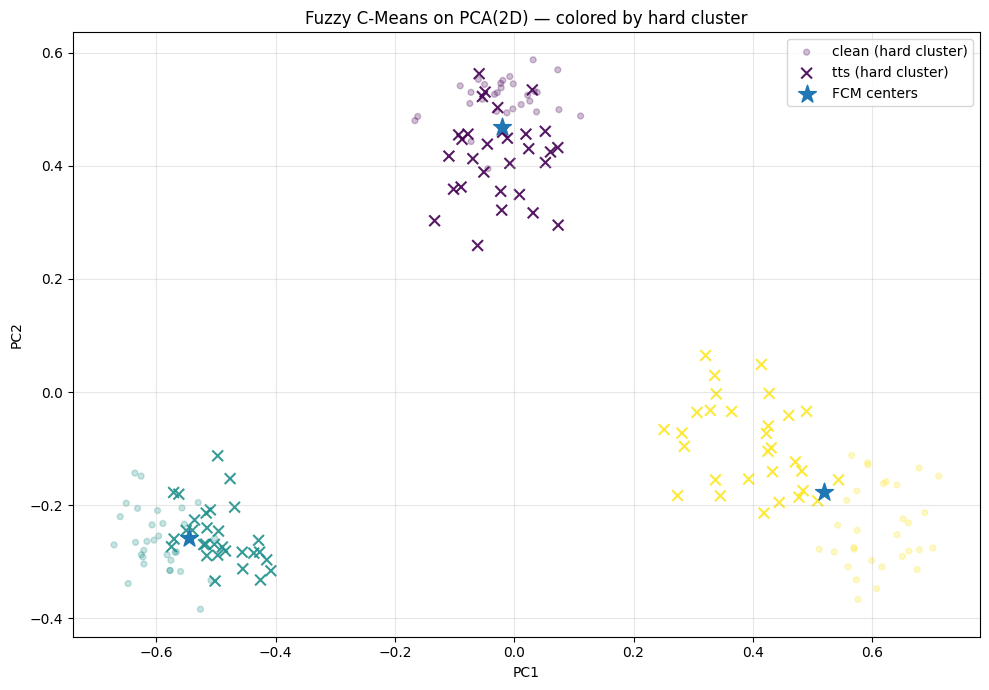

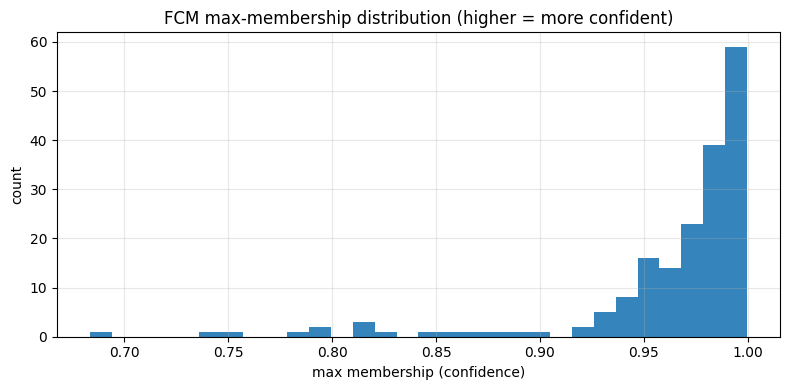

In [16]:

plt.figure(figsize=(10, 7))

mask_clean = (df_all["kind"].to_numpy() == "clean")
mask_tts   = (df_all["kind"].to_numpy() == "tts")

# color by hard cluster id (default colormap)
plt.scatter(X_all[mask_clean, 0], X_all[mask_clean, 1],
            c=hard_cluster[mask_clean], s=18, alpha=0.25, marker="o", label="clean (hard cluster)")

if mask_tts.any():
    plt.scatter(X_all[mask_tts, 0], X_all[mask_tts, 1],
                c=hard_cluster[mask_tts], s=60, alpha=0.9, marker="x", label="tts (hard cluster)")

# cluster centers
plt.scatter(centers[:, 0], centers[:, 1], s=180, marker="*", label="FCM centers")

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Fuzzy C-Means on PCA(2D) — colored by hard cluster")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(max_membership, bins=30, alpha=0.9)
plt.xlabel("max membership (confidence)")
plt.ylabel("count")
plt.title("FCM max-membership distribution (higher = more confident)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

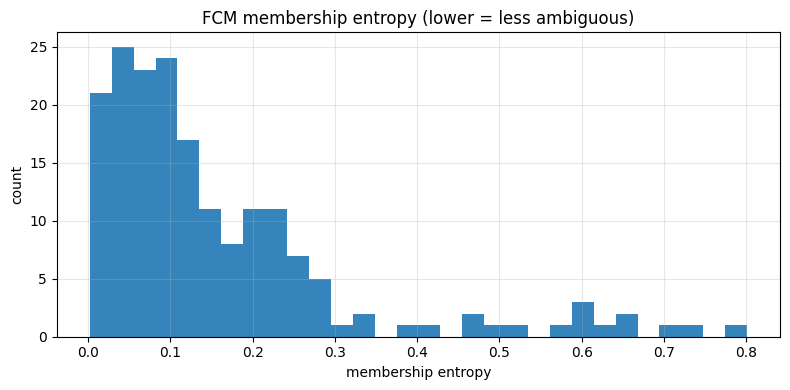

In [17]:
def row_entropy(P: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    P = np.clip(P, eps, 1.0)
    return -np.sum(P * np.log(P), axis=1)

ent = row_entropy(U)
df_all["fcm_entropy"] = ent

plt.figure(figsize=(8, 4))
plt.hist(ent, bins=30, alpha=0.9)
plt.xlabel("membership entropy")
plt.ylabel("count")
plt.title("FCM membership entropy (lower = less ambiguous)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [18]:
clean_true = df_all.loc[df_all["kind"] == "clean", "speaker"].to_numpy()
clean_clu  = df_all.loc[df_all["kind"] == "clean", "fcm_cluster"].to_numpy()

spk_to_idx = {s: i for i, s in enumerate(speakers)}

# brute force best mapping since C is small (3)
best_acc = -1.0
best_perm = None

for perm in permutations(range(C), C):
    # perm[k] tells which speaker index cluster k maps to
    mapped = np.array([speakers[perm[k]] for k in clean_clu], dtype=object)
    acc = float((mapped == clean_true).mean())
    if acc > best_acc:
        best_acc = acc
        best_perm = perm

print("Best cluster->speaker mapping (clean):", best_perm, "accuracy:", best_acc)

mapped_clean_pred = np.array([speakers[best_perm[k]] for k in clean_clu], dtype=object)
print("\nClean (mapped) classification report:")
print(classification_report(clean_true, mapped_clean_pred, labels=speakers, zero_division=0))




Best cluster->speaker mapping (clean): (0, 1, 2) accuracy: 1.0

Clean (mapped) classification report:
              precision    recall  f1-score   support

        eden       1.00      1.00      1.00        30
        idan       1.00      1.00      1.00        31
        yoav       1.00      1.00      1.00        31

    accuracy                           1.00        92
   macro avg       1.00      1.00      1.00        92
weighted avg       1.00      1.00      1.00        92



In [19]:
avg_U = (
    pd.DataFrame(U, columns=[f"cluster_{k}" for k in range(C)])
    .assign(speaker=df_all["speaker"].to_numpy(), kind=df_all["kind"].to_numpy())
    .groupby(["kind", "speaker"])
    .mean()
)

print(avg_U)



               cluster_0  cluster_1  cluster_2
kind  speaker                                 
clean eden      0.981987   0.008505   0.009508
      idan      0.008131   0.986382   0.005487
      yoav      0.020478   0.014114   0.965408
tts   eden      0.965174   0.016621   0.018205
      idan      0.009937   0.982740   0.007323
      yoav      0.069322   0.033216   0.897462
